In [1]:
import utils as u
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib widget

with open('modal_plexi.pkl', 'rb') as f:
    modal_analysis_plexi = pickle.load(f)

modal_analysis_plexi

{'table': 'Plexi',
 'freq': array([ 72.09741278, 142.14215793, 156.59010082, 236.7269505 ,
        248.2530023 , 294.94358678, 337.50039829, 402.02166775,
        444.4563055 , 480.        , 496.89932282, 545.17710008,
        561.25346576, 587.92665334, 652.49382174, 667.70924317,
        691.52147509]),
 'xi': array([-0.00020138, -0.00021048, -0.00045004, -0.00035561, -0.00039229,
        -0.00015262, -0.00050664, -0.00031898, -0.00036209, -0.00027529,
        -0.00058368, -0.00082278, -0.00075488, -0.00037726, -0.00054211,
        -0.00340067, -0.00054211]),
 'ratios': array([1.        , 1.97152925, 2.171924  , 3.28343198, 3.44329973,
        4.0909039 , 4.68117212, 5.57609007, 6.16466373, 6.65765915,
        6.89205484, 7.56167356, 7.78465473, 8.15461513, 9.05016972,
        9.26120949, 9.59148808]),
 'xi_mod': array([-0.07150503, -0.03790774, -0.07357441, -0.03845619, -0.04045318,
        -0.01324686, -0.03842954, -0.02031206, -0.02085583, -0.01468213,
        -0.0300709 , -0.0386

In [3]:
def calcul_e_nu(omega,Lx,Ly,rapport):
    return(rapport * omega**2 / (((np.pi/Lx)**2 + (np.pi/Ly)**2)**2)   )

Lx = 0.40
Ly = 0.26

fond_plexi = 72.09741278
h_plexi = 4.51e-3
masse_plexi = 382e-3
rho_plexi = masse_plexi / (Lx * Ly * h_plexi)
Rapport_plexi = 12 * rho_plexi / h_plexi**2
E_nu_plexi =  calcul_e_nu(2*np.pi*fond_plexi,Lx,Ly,Rapport_plexi)

In [4]:
def omega_pq (p,q,h,E_nu,rho,Lx,Ly) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
    return np.sqrt(E_nu*h**2/(12*rho)) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

def phi_pq (p,q,x,y, Lx, Ly) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
    """
    ## Inputs
    - p : numéro du mode selon x
    - q : numéro du mode selon y
    - x : arrayLike, vecteur des abscisses
    - y : arrayLike, vecteur des ordonnées

    ## Outputs
    - phi_pq : arrayLike, size (Nx,Ny), déformée du mode (p,q) en tous les points (x,y) du maillage
    """
    return np.sin(p*np.pi*x[:,np.newaxis]/Lx)*np.sin(q*np.pi*y[np.newaxis,:]/Ly)

def f_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 

    return(wnB/2/np.pi)
def mode_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 
    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        n, m = NmB_idx[0,mode], NmB_idx[1,mode]
        phiB_NxNy_NmB[:,mode] = phi_pq(n, m , x, y, Lx, Ly).ravel()

    return(wnB/2/np.pi,phiB_NxNy_NmB,x,y)

##phiB_NxNy_NmB[:,j],(Nx,Ny)

In [5]:
f_base,phiB_NxNy_NmB,x,y = mode_plaque(Lx,Ly,h_plexi,E_nu_plexi,rho_plexi)
Nx = len(x)
Ny = len(y)

In [6]:
X_che1 = 13 
Y_che1 = 8

X_che2 = 19
Y_che2 = 11

In [7]:
from data_loader import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


{'0': 'Metal', '1': 'Medium_1', '2': 'Plexi', '3': 'Medium_2'}


In [8]:
idx_mat = 2 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

freq1 = dico_pos1['freq']
FRF1 = dico_pos1['FRF']

freq2 = dico_pos2['freq']
FRF2 = dico_pos2['FRF']

f_fond = modal_analysis_plexi['freq']

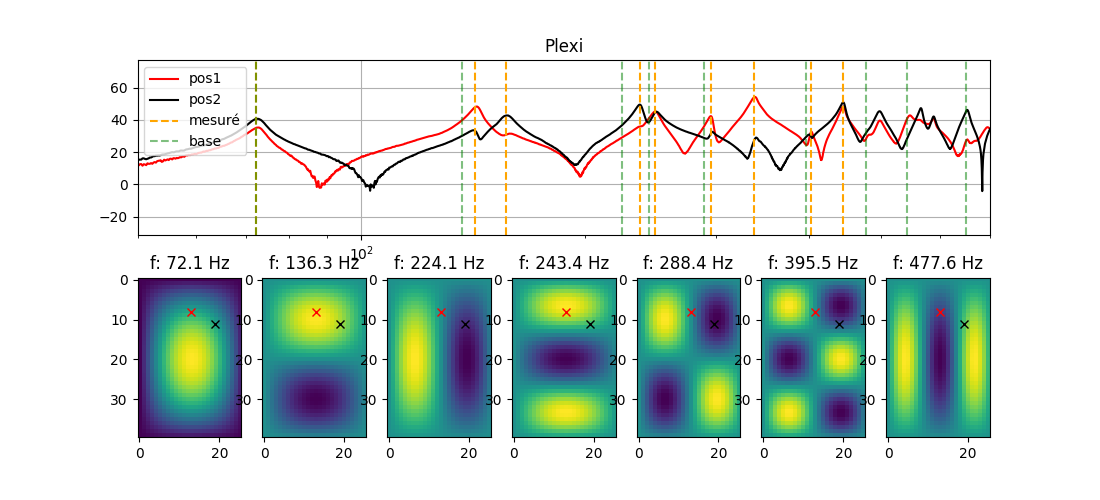

In [9]:
N_mode= 7
plt.figure(figsize=(11,5))
a1 = plt.subplot2grid((2,N_mode),(0,0),colspan = N_mode)
a1.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
a1.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
a1.set_title(dico_pos1["mat_table"])
a1.axvline(f_fond[0],ls='--',color='orange',label='mesuré')
a1.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    a1.axvline(f_fond[i],ls='--',color='orange')
    a1.axvline(f_base[i],ls='--',color='green',alpha=0.5)

a1.grid()
a1.legend()
a1.set_xlim(50,700)
for i in range(N_mode):
    ax = plt.subplot2grid((2,N_mode),(1,i),rowspan = 1, colspan = 1)
    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)))
    ax.plot(X_che1,Y_che1,'rx',label='pos1')
    ax.plot(X_che2,Y_che2,'kx',label='pos2')
    ax.set_title(f'f: {f_base[i]:0.1f} Hz')
plt.show()

In [10]:
f_bon = [f_fond[0],f_fond[1],f_fond[2],206,f_fond[3],f_fond[4]]
print(f_bon)

[72.09741278, 142.14215793, 156.59010082, 206, 236.7269505, 248.2530023]


In [17]:
def optimisation(f_bon,h,E_nu,rhoT,Lx,Ly,plot=False):
    pourcentage = 0.30
    idx_max = len(f_bon)
    XX = np.linspace(Lx*(1 - pourcentage),Lx*(1+pourcentage),100)
    YY = np.linspace(Ly*(1 - pourcentage),Ly*(1+pourcentage),100)
    ZZ = np.linspace(E_nu*(1 - pourcentage),E_nu*(1+pourcentage),100)
    cout = np.zeros((len(XX),len(YY),len(ZZ)))

    pondération = [50,25]
    pondération = np.concatenate((pondération,[1]*(len(f_bon)-2)))
    #pondération = np.ones_like(f_bon)
    for ii,i in enumerate(XX) :
        for jj,j in enumerate(YY):
            for zz,z in enumerate(ZZ):
                f_optim = f_plaque(i,j,h,z,rhoT)
                cout[ii,jj,zz] = np.sum(np.abs(pondération * (f_bon - f_optim[:idx_max])))
            

    xxx, yyy,zzz=  np.unravel_index(cout.argmin(), cout.shape)
    Lx_final, Ly_final, E_nu_finale = XX[xxx],YY[yyy], ZZ[zzz]
    if plot :
        extent = np.min(YY), np.max(YY), np.min(XX), np.max(XX)
        plt.figure()        
        plt.scatter(YY[yyy],XX[xxx],label="point choisi")
        plt.imshow(1-cout/np.max(cout),cmap='inferno',extent=extent)
        plt.xlabel("Variation en Y")
        plt.ylabel("Variation en X")
        plt.legend()
        plt.title("Fonction de cout en fonction des valeurs de X et de Y")
        plt.colorbar()
        plt.show()
        
    return(Lx_final, Ly_final,E_nu_finale,cout)

            


In [18]:
Lx_op,Ly_op,E_nu_finale,cout = optimisation(f_bon,h_plexi,E_nu_plexi,rho_plexi,Lx,Ly)
Lx_op,Ly_op,E_nu_finale

(0.40848484848484845, 0.28284848484848485, 2957903678.604968)

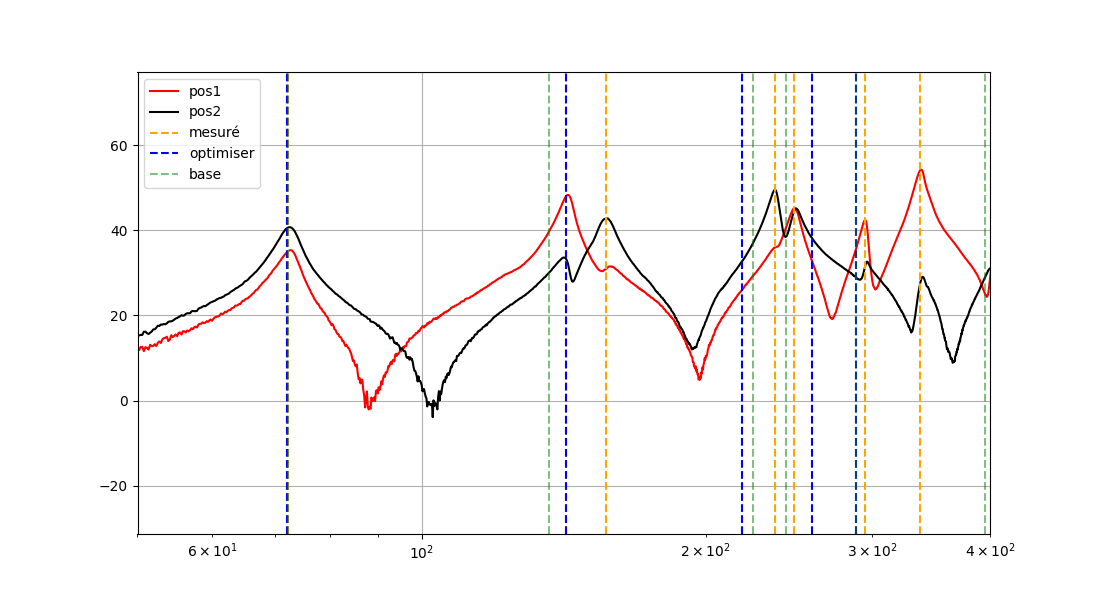

In [20]:
f_op = f_plaque(Lx_op, Ly_op,h_plexi,E_nu_finale,rho_plexi)
plt.figure(figsize = (11,6))
plt.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
plt.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
plt.axvline(f_fond[0],ls='--',color='orange',label = 'mesuré')
plt.axvline(f_op[0],ls='--',color='blue',label="optimiser")
plt.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    plt.axvline(f_fond[i],ls='--',color='orange')
    plt.axvline(f_op[i],ls='--',color='blue')
    plt.axvline(f_base[i],ls='--',color='green',alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(50,400)
plt.show()